In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [2]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy

def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended


def is_mjj(month):
    return (month>=5) & (month<=7)

def is_mam(month):
    return (month>=3) & (month<=5)

def is_jja(month):
    return (month>=6) & (month<=8)

def is_nd(month):
    return (month==11) | (month==12)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'


dir_tos_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/'
dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/'
#dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/HadI-SST/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'

period_str = 1985
period_end = 2004
%matplotlib inline



/tmp/ipykernel_16029/1402327608.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# ORA-S5

In [3]:

sst_oras5_tmp = xr.open_dataset(dir_obs_sst+'ORA-S5/sosstsst_merged_r360x180_oras5_1984_2005.nc')
sst_oras5_tmp = sst_oras5_tmp.sosstsst[:] # K to degC
sst_oras5 = sst_oras5_tmp.sel(time_counter=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_oras5_arr = np.array(sst_oras5)
sst_oras5_atl_dtd = np.ones((sst_oras5_arr.shape))*np.nan
for i in range(sst_oras5_atl_dtd.shape[1]):
    for j in range(sst_oras5_atl_dtd.shape[2]):
        sst_oras5_atl_dtd[:,i,j] = nandetrend(sst_oras5_arr[:,i,j])
        
        
sst_oras5_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_oras5_atl_dtd)}
                       ,coords={'time':np.array(sst_oras5.time_counter),
                                'lon':np.array(sst_oras5.lon),
                                'lat':np.array(sst_oras5.lat)
                                })
        
sst_oras5_atl3 = Atools.data_sub(sst_oras5_atl_dtd_xarray,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(sst_oras5_atl_dtd_xarray,-20,0,-3,3).lat))).mean(('lon','lat'))
ssta_oras5_atl3_dtd,_ = Atools.ano_norm_t(sst_oras5_atl3.sst_dtd)
ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd.sel(time=is_mjj(
    ssta_oras5_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd_mjj.std(dim='year')

In [4]:
ssta_oras5_atl_dtd,_ = Atools.ano_norm_t(sst_oras5_atl_dtd_xarray.sst_dtd)

ssta_oras5_atl_dtd_mjj = ssta_oras5_atl_dtd.sel(time=is_mjj(
    ssta_oras5_atl_dtd['time.month'])).groupby('time.year').mean()

std_ssta_oras5_atl_dtd_mjj = ssta_oras5_atl_dtd_mjj.std(dim='year')


# OMIP1

In [5]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)


omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


In [6]:
def get_sst_omip1_atl(directory,model):
    print(directory+model+'/r1i1p1f1/ATL/*.nc')
    sst_omip1 = xr.open_dataset(
        directory+model+'/r1i1p1f1/ATL/tos_merged_standard_'+str(model)+'_r360x180_atl.nc',use_cftime=True)
    sst_omip1 = sst_omip1.tos[4*744:5*744,:,:]
    time_new = pd.date_range('1948-01-15', freq='M',periods=sst_omip1.time.shape[0])
    sst_omip1['time'] = time_new
    sst_omip1 = sst_omip1.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
    
    sst_omip1_atl = Atools.data_sub(sst_omip1,-45,20,-30,10)
    sst_omip1_atl_arr = np.array(sst_omip1_atl)
    sst_omip1_atl_dtd = np.ones((sst_omip1_atl_arr.shape))*np.nan
    for i in range(sst_omip1_atl.shape[1]):
        for j in range(sst_omip1_atl.shape[2]):
            sst_omip1_atl_dtd[:,i,j] = nandetrend(sst_omip1_atl_arr[:,i,j])
             

    sst_omip1_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_omip1_atl_dtd)}
                       ,coords={'time':np.array(sst_omip1_atl.time),
                                'lon':np.array(sst_omip1_atl.lon),
                                'lat':np.array(sst_omip1_atl.lat)
                                })
    
    
    ssta_omip1_atl_dtd,_ = Atools.ano_norm_t(sst_omip1_atl_dtd_xarray.sst_dtd)

    return ssta_omip1_atl_dtd,sst_omip1_atl_dtd_xarray.sst_dtd


def get_sst_omip2_atl(directory,model):
    print(directory+model+'/r1i1p1f1/ATL/*.nc')
    sst_omip1 = xr.open_dataset(
        directory+model+'/r1i1p1f1/ATL/tos_merged_standard_'+str(model)+'_r360x180_atl.nc',use_cftime=True)
    sst_omip1 = sst_omip1.tos[5*732:6*732,:,:]
    print(sst_omip1.time)
    time_new = pd.date_range('1958-01-15', freq='M',periods=sst_omip1.time.shape[0])
    sst_omip1['time'] = time_new
    sst_omip1 = sst_omip1.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
    
    sst_omip1_atl = Atools.data_sub(sst_omip1,-45,20,-30,10)
    sst_omip1_atl_arr = np.array(sst_omip1_atl)
    sst_omip1_atl_dtd = np.ones((sst_omip1_atl_arr.shape))*np.nan
    for i in range(sst_omip1_atl.shape[1]):
        for j in range(sst_omip1_atl.shape[2]):
            sst_omip1_atl_dtd[:,i,j] = nandetrend(sst_omip1_atl_arr[:,i,j])
             

    sst_omip1_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_omip1_atl_dtd)}
                       ,coords={'time':np.array(sst_omip1_atl.time),
                                'lon':np.array(sst_omip1_atl.lon),
                                'lat':np.array(sst_omip1_atl.lat)
                                })
    
    
    ssta_omip1_atl_dtd,_ = Atools.ano_norm_t(sst_omip1_atl_dtd_xarray.sst_dtd)

    return ssta_omip1_atl_dtd,sst_omip1_atl_dtd_xarray.sst_dtd

# Loop OMIP1 models

In [7]:
test,_ = get_sst_omip1_atl(dir_tos_omip1,omip1_models[2])


/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/EC-Earth3/r1i1p1f1/ATL/*.nc


In [8]:
ssta_omip1_atl = np.ones((len(omip1_models),test.shape[0],test.shape[1],test.shape[2]))*np.nan
sst_omip1_atl = np.ones((len(omip1_models),test.shape[0],test.shape[1],test.shape[2]))*np.nan
for i in range(len(omip1_models)):
    ssta_omip1_atl[i,:,:,:],sst_omip1_atl[i,:,:,:]= get_sst_omip1_atl(dir_tos_omip1,omip1_models[i])

/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/CMCC-CM2-SR5/r1i1p1f1/ATL/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/CMCC-ESM2/r1i1p1f1/ATL/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/EC-Earth3/r1i1p1f1/ATL/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/IPSL-CM6A-LR/r1i1p1f1/ATL/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/MRI-ESM2-0/r1i1p1f1/ATL/*.nc
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/tos/mon/NorESM2-LM/r1i1p1f1/ATL/*.nc


In [9]:
ssta_omip1_atl_all  = xr.Dataset({'ssta': (['model','time','lat','lon'],ssta_omip1_atl),
                                  'sst': (['model','time','lat','lon'],sst_omip1_atl)}
                       ,coords={'model':np.array(omip1_models),
                                'time':np.array(test.time),
                                'lon': np.array(test.lon),
                                'lat': np.array(test.lat)
                                })


In [10]:
#ssta_omip1_atl_all.to_netcdf(path_data_out+'sst_ssta_omip1_atl_1985_2004.nc','w')

In [11]:
ssta_omip1_atl_all_mjj = ssta_omip1_atl_all.ssta.sel(time=is_mjj(
    ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip1_atl_all_mam = ssta_omip1_atl_all.ssta.sel(time=is_mam(
    ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip1_atl_all_nd = ssta_omip1_atl_all.ssta.sel(time=is_nd(
    ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()

In [12]:
sst_omip1_atl_all = ssta_omip1_atl_all.sst.mean(dim='time')
var_ssta_omip1_atl_all_mam = ssta_omip1_atl_all_mam.var(dim='year')
var_ssta_omip1_atl_all_mjj = ssta_omip1_atl_all_mjj.var(dim='year')
var_ssta_omip1_atl_all_nd = ssta_omip1_atl_all_nd.var(dim='year')

In [13]:
std_ssta_omip1_atl_all_mam = np.sqrt(var_ssta_omip1_atl_all_mam.mean(dim='model'))
std_ssta_omip1_atl_all_mjj = np.sqrt(var_ssta_omip1_atl_all_mjj.mean(dim='model'))
std_ssta_omip1_atl_all_nd = np.sqrt(var_ssta_omip1_atl_all_nd.mean(dim='model'))

In [14]:
std_ssta_omip1_atl_all = np.sqrt(ssta_omip1_atl_all.ssta.var(dim='time').mean(dim='model'))

# Loop on OMIP2 models

In [15]:
test2,_ = get_sst_omip2_atl(dir_tos_omip2,omip2_models[2])


/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/CMCC-CM2-HR4/r1i1p1f1/ATL/*.nc
<xarray.DataArray 'time' (time: 732)>
array([cftime.DatetimeGregorian(1958, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1958, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1958, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(2018, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T


In [16]:
ssta_omip2_atl = np.ones((len(omip2_models),test2.shape[0],test2.shape[1],test2.shape[2]))*np.nan
sst_omip2_atl = np.ones((len(omip2_models),test2.shape[0],test2.shape[1],test2.shape[2]))*np.nan
for i in range(len(omip2_models)):
    print(omip2_models[i])
    ssta_omip2_atl[i,:,:,:],sst_omip2_atl[i,:,:,:]= get_sst_omip2_atl(dir_tos_omip2,omip2_models[i])

ACCESS-OM2
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2/r1i1p1f1/ATL/*.nc
<xarray.DataArray 'time' (time: 732)>
array([cftime.DatetimeGregorian(306, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(306, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(306, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(366, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(366, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(366, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 0306-01-16 12:00:00 ... 0366-12-16 12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
ACCESS-OM2-025
/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/tos/mon/ACCESS-OM2-025/r1i1p1f1/ATL/*.nc
<xarray.DataArray 'time' (time: 732)

In [17]:
ssta_omip2_atl_all  = xr.Dataset({'ssta': (['model','time','lat','lon'],ssta_omip2_atl),
                                 'sst': (['model','time','lat','lon'],sst_omip2_atl)}
                       ,coords={'model':np.array(omip2_models),
                                'time':np.array(test2.time),
                                'lon': np.array(test2.lon),
                                'lat': np.array(test2.lat)
                                })

In [18]:
ssta_omip2_atl_all_mjj = ssta_omip2_atl_all.ssta.sel(time=is_mjj(
    ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip2_atl_all_mam = ssta_omip2_atl_all.ssta.sel(time=is_mam(
    ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()

ssta_omip2_atl_all_nd = ssta_omip2_atl_all.ssta.sel(time=is_nd(
    ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()

In [19]:
#ssta_omip2_atl_all.to_netcdf(path_data_out+'sst_ssta_omip2_atl_1985_2004.nc','w')

In [20]:
sst_omip2_atl_all = ssta_omip2_atl_all.sst.mean(dim='time')
var_ssta_omip2_atl_all_mam = ssta_omip2_atl_all_mam.var(dim='year')
var_ssta_omip2_atl_all_mjj = ssta_omip2_atl_all_mjj.var(dim='year')
var_ssta_omip2_atl_all_nd = ssta_omip2_atl_all_nd.var(dim='year')


std_ssta_omip2_atl_all_mam = np.sqrt(var_ssta_omip2_atl_all_mam.mean(dim='model'))
std_ssta_omip2_atl_all_mjj = np.sqrt(var_ssta_omip2_atl_all_mjj.mean(dim='model'))
std_ssta_omip2_atl_all_nd = np.sqrt(var_ssta_omip2_atl_all_nd.mean(dim='model'))

# Concatenate the OMIP models together

In [21]:
std_ssta_omip2_atl_all = np.sqrt(ssta_omip2_atl_all.ssta.var(dim='time').mean(dim='model'))

In [22]:
ssta_std_omips = xr.concat([np.sqrt(var_ssta_omip1_atl_all_mjj),
                            np.sqrt(var_ssta_omip2_atl_all_mjj)],dim='model')

# MOM

In [23]:
ssta_mom_atl = xr.open_dataset(path_data_out+'tos_mom_atl_1985_2004.nc')
ssta_mom_atl_mjj = ssta_mom_atl.tosa_atl.sel(time=is_mjj(
    ssta_mom_atl.tosa_atl['time.month'])).groupby('time.year').mean()
std_ssta_mom_atl_mjj = ssta_mom_atl_mjj.std(dim='year')

In [24]:
ssta_mom025_atl = xr.open_dataset(path_data_out+'tos_mom025_atl_1985_2004.nc')
ssta_mom025_atl_mjj = ssta_mom025_atl.tosa_atl.sel(time=is_mjj(
    ssta_mom025_atl.tosa_atl['time.month'])).groupby('time.year').mean()
std_ssta_mom025_atl_mjj = ssta_mom025_atl_mjj.std(dim='year')

In [25]:
ssta_momcore2_atl = xr.open_dataset(path_data_out+'tos_mom_core2_atl_1985_2004.nc')

ssta_mom_core2_atl_mjj = ssta_momcore2_atl.tosa_atl.sel(time=is_mjj(
    ssta_momcore2_atl.tosa_atl['time.month'])).groupby('time.year').mean()
std_ssta_mom_core2_atl_mjj = ssta_mom_core2_atl_mjj.std(dim='year')

In [26]:
ssta_momcore2_heat_atl = xr.open_dataset(path_data_out+'tos_mom_core2_heat_atl_1985_2004.nc')


ssta_momcore2_heat_atl_mjj = ssta_momcore2_heat_atl.tosa_atl.sel(time=is_mjj(
    ssta_momcore2_heat_atl.tosa_atl['time.month'])).groupby('time.year').mean()
std_ssta_momcore2_heat_atl_mjj = ssta_momcore2_heat_atl_mjj.std(dim='year')

# Figure S02 

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


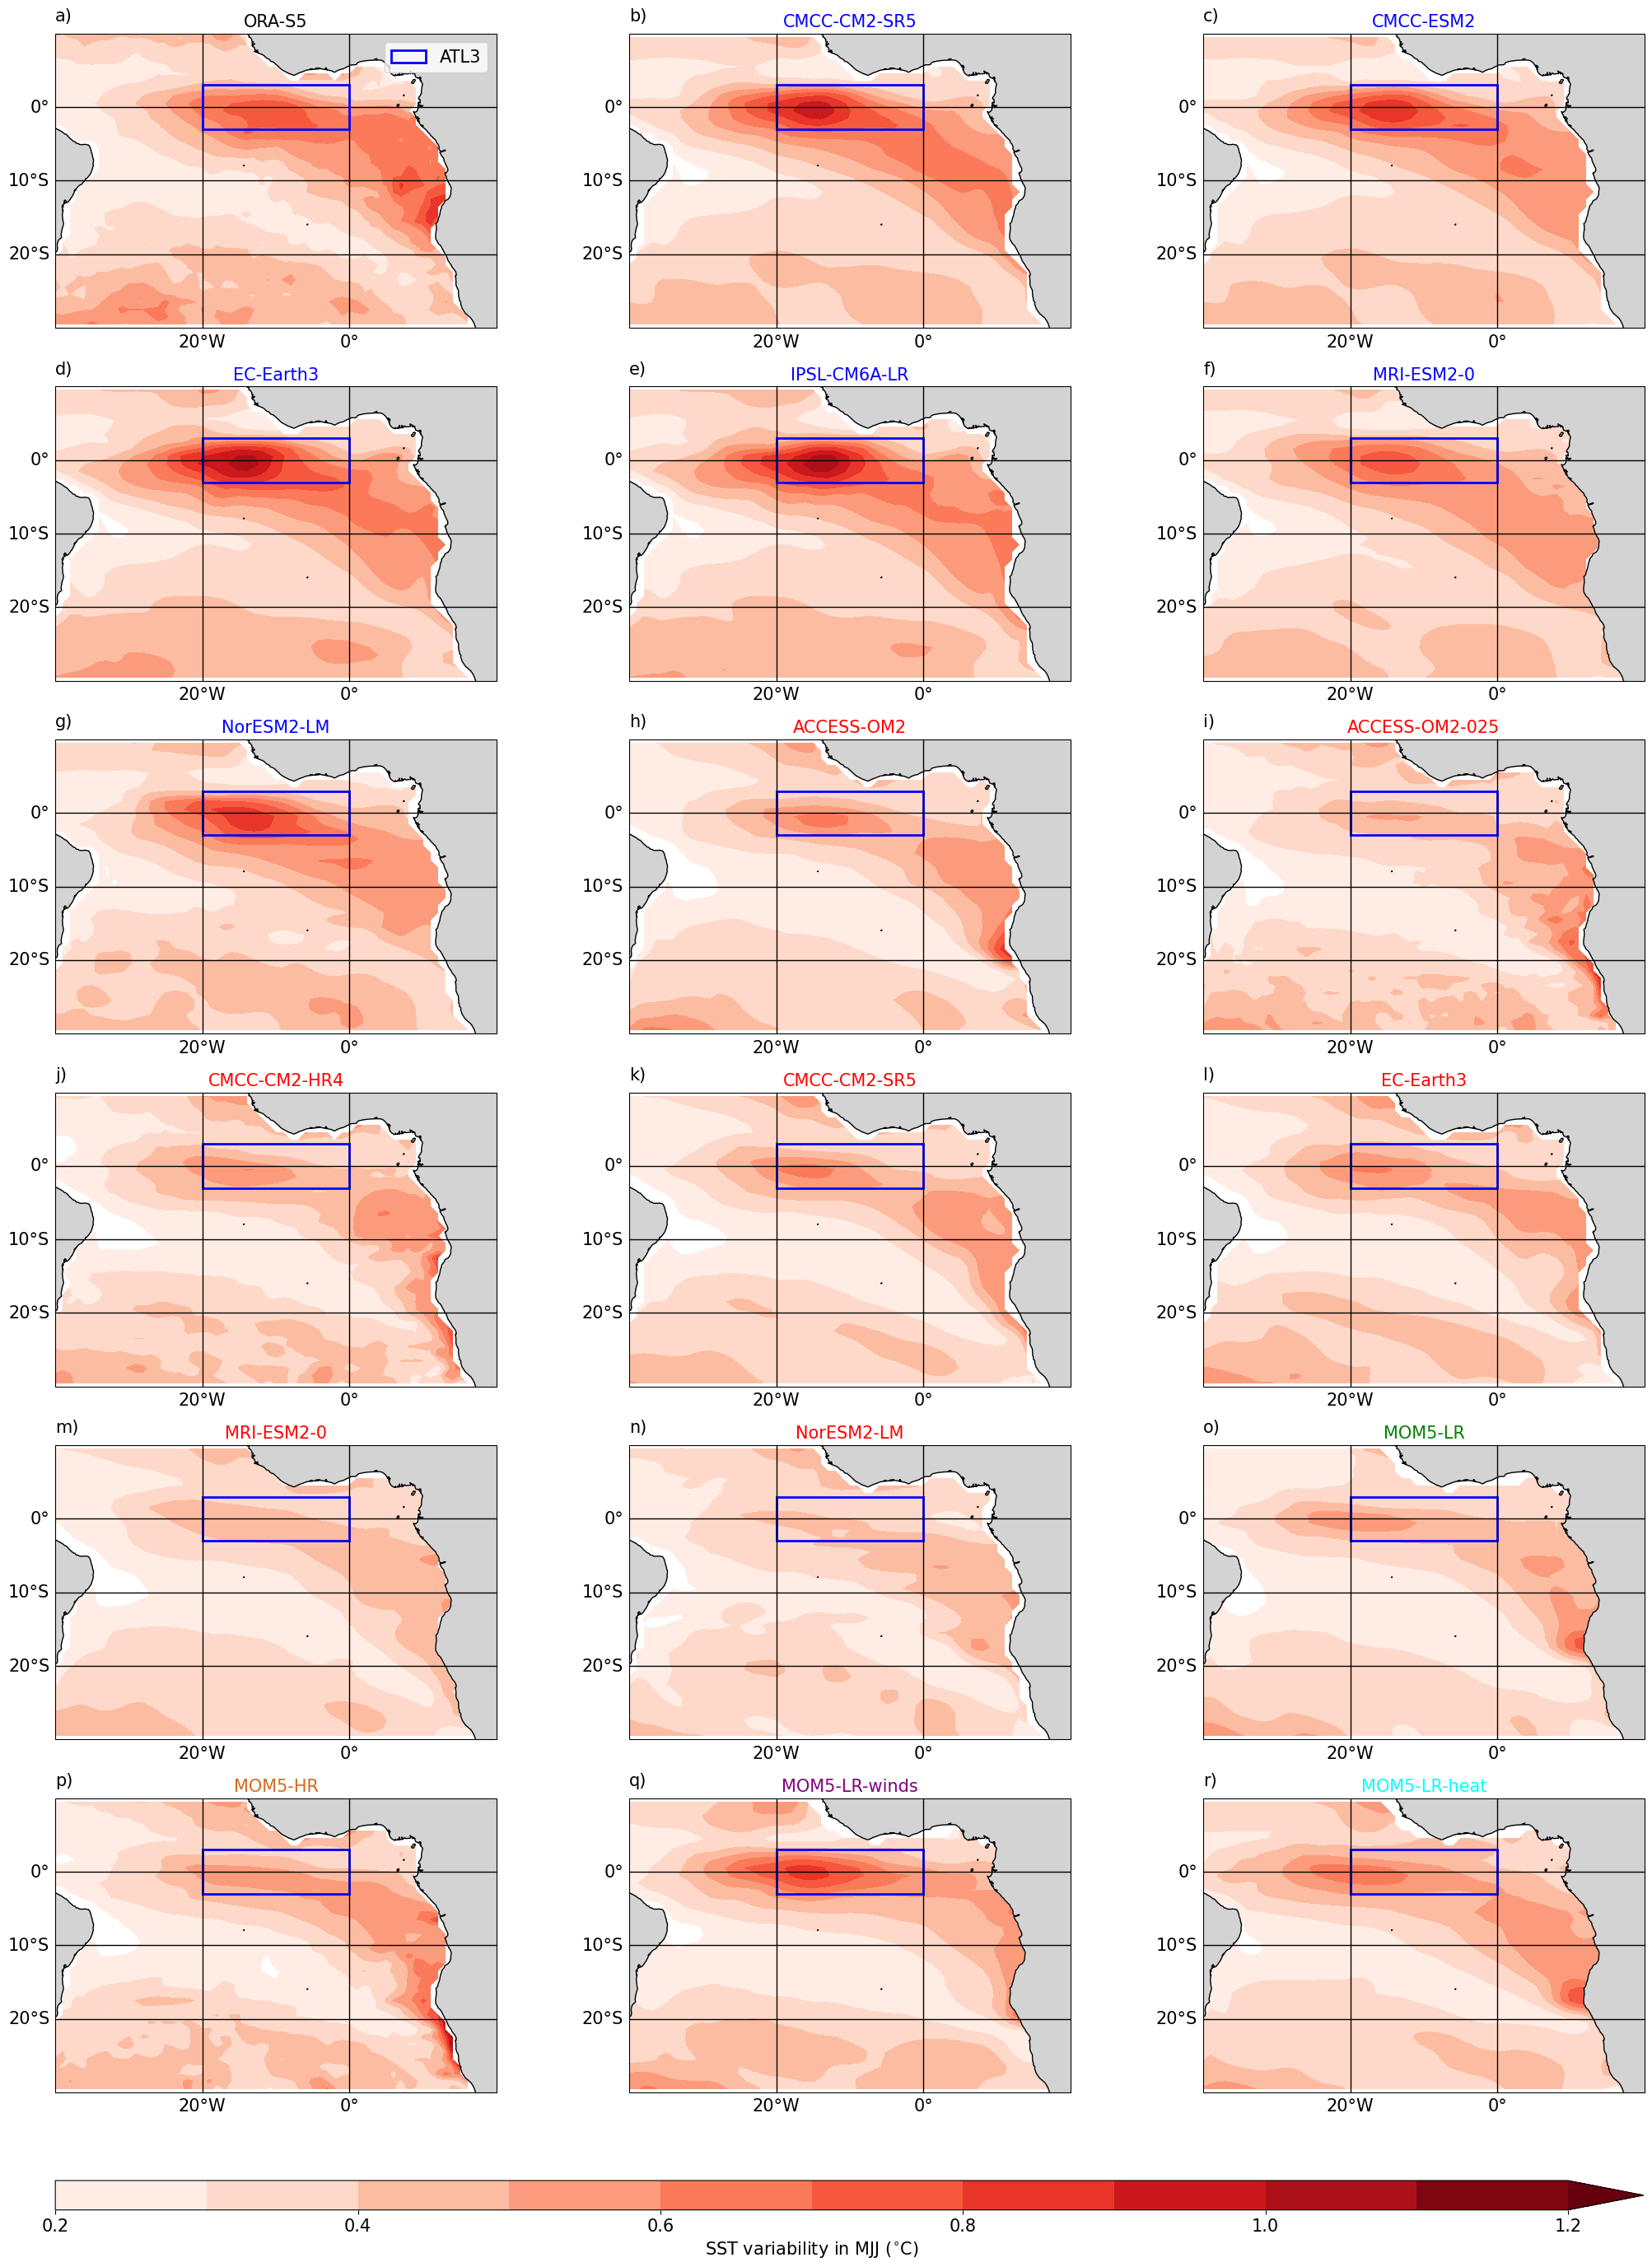

In [27]:

ftz=15
f,ax = plt.subplots(6,3,figsize=[20,25], subplot_kw={'projection': ccrs.PlateCarree()})
f.patch.set_facecolor('white')
m = np.arange(1,13,1)
ax = ax.ravel()
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.2, wspace=0.15)
levels = np.arange(0.2,1.3,0.1)
cmap = plt.cm.Reds


levels0 = np.arange(14,30,1)
cmap0 = plt.cm.RdYlBu_r



cax0 = inset_axes(ax[15],
                 width='360%',
                 height='10%',
                 loc = 'lower left',
                 bbox_to_anchor=(0,-0.4,1,1),
                 bbox_transform=ax[15].transAxes,
                 borderpad=0)






## d) ##

p0 = ax[0].contourf(std_ssta_oras5_atl_dtd_mjj.lon,
               std_ssta_oras5_atl_dtd_mjj.lat,
               std_ssta_oras5_atl_dtd_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')
ax[0].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))


gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[0].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[0].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[0].set_xlim([-40,20])
ax[0].set_ylim([-30,10])
ax[0].set_title('ORA-S5',fontsize=ftz)
ax[0].legend(fontsize=ftz)
cbar = plt.colorbar(p0,cax0,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('SST variability in MJJ ($^{\circ}$C)',fontsize=ftz)
ax[0].text(0,1.06,string.ascii_lowercase[0]+')',transform=ax[0].transAxes,size=ftz,verticalalignment='center')



## e) ##

ssta_std_omips
index_fig = np.arange(1,13,1)

for i in range(ssta_std_omips.shape[0]):

    ax[i+1].contourf(ssta_std_omips.lon,
                   ssta_std_omips.lat,
                   ssta_std_omips[i,:,:],
                   cmap = cmap,
                   levels = levels,transform=ccrs.PlateCarree(),extend='max')
    gl = ax[i+1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                      linestyle='-',zorder=2)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': ftz, 'color': 'black'}
    gl.ylabel_style = {'size': ftz, 'color': 'black'}
    gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
    gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
    ax[i+1].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
    ax[i+1].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
    ax[i+1].set_xlim([-40,20])
    ax[i+1].set_ylim([-30,10])
    if i<6:
        ax[i+1].set_title(ssta_std_omips.model[i].values,fontsize=ftz,color='blue')
    else:
        ax[i+1].set_title(ssta_std_omips.model[i].values,fontsize=ftz,color='red')
    ax[i+1].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                       width=20,
                                       height=6,
                                       edgecolor='blue',
                                       fill=None,
                                       alpha=1,linewidth=2,zorder=2,label='ATL3'))
    ax[i+1].text(0,1.06,string.ascii_lowercase[i+1]+')',transform=ax[i+1].transAxes,size=ftz,

               verticalalignment='center')
    
    
    
ax[14].contourf(std_ssta_mom_atl_mjj.lon,
               std_ssta_mom_atl_mjj.lat,
               std_ssta_mom_atl_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')
gl = ax[14].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[14].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[14].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[14].set_xlim([-40,20])
ax[14].set_ylim([-30,10])
ax[14].set_title('MOM5-LR',fontsize=ftz,color='green')
ax[14].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))
ax[14].text(0,1.06,string.ascii_lowercase[14]+')',transform=ax[14].transAxes,size=ftz,
           verticalalignment='center')




ax[15].contourf(std_ssta_mom025_atl_mjj.lon,
               std_ssta_mom025_atl_mjj.lat,
               std_ssta_mom025_atl_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')
gl = ax[15].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[15].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[15].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[15].set_xlim([-40,20])
ax[15].set_ylim([-30,10])
ax[15].set_title('MOM5-HR',fontsize=ftz,color='chocolate')
ax[15].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))
ax[15].text(0,1.06,string.ascii_lowercase[15]+')',transform=ax[15].transAxes,size=ftz,
           verticalalignment='center')




ax[16].contourf(std_ssta_mom_core2_atl_mjj.lon,
               std_ssta_mom_core2_atl_mjj.lat,
               std_ssta_mom_core2_atl_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')
gl = ax[16].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[16].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[16].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[16].set_xlim([-40,20])
ax[16].set_ylim([-30,10])
ax[16].set_title('MOM5-LR-winds',fontsize=ftz,color='purple')
ax[16].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))
ax[16].text(0,1.06,string.ascii_lowercase[16]+')',transform=ax[16].transAxes,size=ftz,
           verticalalignment='center')




ax[17].contourf(std_ssta_momcore2_heat_atl_mjj.lon,
               std_ssta_momcore2_heat_atl_mjj.lat,
               std_ssta_momcore2_heat_atl_mjj,
               cmap = cmap,
               levels = levels,transform=ccrs.PlateCarree(),extend='max')
gl = ax[17].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=1,
                  linestyle='-',zorder=2)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': ftz, 'color': 'black'}
gl.ylabel_style = {'size': ftz, 'color': 'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0,20])
gl.ylocator = mticker.FixedLocator([-20,-10,0,10])
ax[17].add_feature(cartopy.feature.COASTLINE,zorder=3)# add coastlines
ax[17].add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=1)# add coastlines
ax[17].set_xlim([-40,20])
ax[17].set_ylim([-30,10])
ax[17].set_title('MOM5-LR-heat',fontsize=ftz,color='cyan')
ax[17].add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3'))
ax[17].text(0,1.06,string.ascii_lowercase[17]+')',transform=ax[17].transAxes,size=ftz,
           verticalalignment='center')


#ax[-1].axis('off')

plt.savefig(path_fig+'figure_S02.png',bbox_inches='tight',dpi=300)